# 8.3 Lab: Decision Trees

## 8.3.2 Fitting Regression Trees

Demonstrate the fitting of decision trees for regression using the `Boston` data set from the `MASS` package. We will use the `statsmodels` library to load the R `data.frame` into a `pandas.core.frame.DataFrame` object.

We will use the `sklearn.tree` namespace and its associated classifers for [Decision Trees](https://scikit-learn.org/stable/modules/tree.html).

> Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.


In [5]:
from typing import List, Dict, Tuple, Sequence, Union

import statsmodels # root namespace for typing
import statsmodels.api as statsModels # alias to hide the extra api namespace

import numpy
import pandas 

import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as pyplot

## Support Functions

The below support function prints out summary information of a fitted tree and will provide the training or test error if the test data is provided.    

In [82]:
def DecisionTreeSummary (decisionTree, trainX: numpy.ndarray, trainy: numpy.ndarray, 
            testX: numpy.ndarray = None, testy: numpy.ndarray = None):
    """
    This method will print the summary statistics of a fitted decision tree 
    estimator (classifier). 

    Parameters 
    ----------
    decisionTree: DecisionTreeClassifier | DecisionTreeRegressor
        fitted decision tree
    trainX: numpy.ndarray
        the training data X
    trainy: numpy.ndarray
        the training data y
    testX: numpy.ndarray (optional)
        the test data X
    texty: numpy.ndarray (optional)
        the test data y

    Returns
    -------
    list: an array of all nodes within the tree graph 

    """

    nodes = numpy.zeros (shape = decisionTree.tree_.node_count, dtype = object)
    for index in range (0, decisionTree.tree_.node_count):
        nodes [index] = { "index": index, "parentIndex": -1, "depth": -1, "isLeaf": False, "samples": -1, "class": -1, "mse": 0 }

    nodeStack = [(0, -1, -1)] # root node index, parent index, parent depth

    # transverse the tree to identify all the nodes starting at the root index
    while (len (nodeStack)> 0):
        nodeIndex, parentIndex, parentDepth = nodeStack.pop ()
        nodes [nodeIndex]["index"] = nodeIndex
        nodes [nodeIndex]["parentIndex"] = parentIndex
        nodes [nodeIndex]["depth"] = parentDepth + 1

        if isinstance (decisionTree, sklearn.tree.DecisionTreeRegressor):
            nodes [nodeIndex]["mse"] = max (decisionTree.tree_.impurity [nodeIndex].ravel ()).round (4)

        # if the node is a branch node, let's push both branches into the stack for processing
        if (decisionTree.tree_.children_left [nodeIndex] != decisionTree.tree_.children_right [nodeIndex]):
            nodeStack.append ((decisionTree.tree_.children_left  [nodeIndex], nodeIndex, parentDepth + 1))
            nodeStack.append ((decisionTree.tree_.children_right [nodeIndex], nodeIndex, parentDepth + 1))
        else: 
            # we have arrived at a terminal node, do not add to stack for processing, but update node properties
            nodes [nodeIndex]["isLeaf"] = True 
            nodes [nodeIndex]["samples"] = int (max (decisionTree.tree_.value [nodeIndex].ravel ()))
            nodes [nodeIndex]["class"] = 0 if  (decisionTree.tree_.value [nodeIndex].ravel ()[0]) > 0 else 1

    # print the summary of the model fit
    print ("Classification tree: ")
    print (decisionTree)

    # this is based on the feature importance being greater than 0
    print ("Variables actually used in tree construction:")
    print (X.columns [decisionTree.feature_importances_ > 0])

    print ("Number of terminal nodes: " + str (decisionTree.get_n_leaves ()))
    totalObservations = len (trainX)


    if isinstance (decisionTree, sklearn.tree.DecisionTreeClassifier): 

        # TODO: The deviance calculation needs to be validated as it was quickly 
        # implemented and the p-hat does not seem to be the correct formula
        # calculate the deviance as -2 \sum_m \sum_k { n_mk log (p-hat_mk) }
        # where n_mn is the number of observations in the mth terminal node that belong to the kth class
        # a small deviance indicates a tree that provides a good fit to the training data (the data it has seen)
        # residual mean deviance is the deviance / (n - |T_0|), deviance / (n - # of terminal nodes)
        deviance: float = 0.0

        for currentClass in decisionTree.classes_:
            terminalNodes = list (filter (lambda node: ((node ["isLeaf"]) and (node ["class"] == currentClass)), nodes))

            for currentTerminalNode in terminalNodes: 
                # this formula may not be calculating correctly (p-hat needs review)
                samples = currentTerminalNode ["samples"] # n_mk
                phat = samples / totalObservations # p-hat_mk
                deviance = deviance + (samples * numpy.log (phat))

        deviance = deviance * -2
        meanDeviance = deviance / (totalObservations - decisionTree.get_n_leaves ())

        print ("Residual mean deviance: " + "{:.4f}".format (meanDeviance) + " = " + "{:.2f}".format (deviance)  + " / " + str (totalObservations - decisionTree.get_n_leaves ()))
        print ("Misclassification error rate: " + "{:.2f}".format (1 - sklearn.metrics.accuracy_score (trainy, decisionTree.predict (trainX))))

        if (testy is None):
            print ("\nTraining Error Classification Report")
            print (sklearn.metrics.classification_report (trainy, decisionTree.predict (trainX)))
        else: 
            print ("\nTest Error Classification Report")
            print (sklearn.metrics.classification_report (testy, decisionTree.predict (testX)))
            print ("\nTest Confusion Matrix")
            print (sklearn.metrics.confusion_matrix (testy, decisionTree.predict (testX)))

    elif isinstance (decisionTree, sklearn.tree.DecisionTreeRegressor): 
        deviance = sum (numpy.square (list (map (lambda node: node ["mse"], list (filter (lambda node: node ["isLeaf"], decisionTreeNodes))))))
        meanDeviance = deviance / (totalObservations - decisionTree.get_n_leaves())
        print ("Residual mean deviance: " + "{:.4f}".format (meanDeviance) + " = " + "{:.2f}".format (deviance)  + " / " + str (totalObservations - decisionTree.get_n_leaves ()))        

        print ("Distribution of residuals: ")
        yhat = decisionTree.predict (trainX if testX is None else testX)
        truthy = trainy if testy is None else testy

        residuals = truthy - yhat
        print (pandas.DataFrame (residuals).describe ().transpose ().round (3))

    return nodes

## Data Acquisition

In [16]:
# download the R data set as a pandas DataFrame
bostonDataSet: statsmodels.datasets.utils.Dataset = statsModels.datasets.get_rdataset ("Boston", "MASS")

# print out the help information on the data set to get the column documentation
print (bostonDataSet.__doc__)

+--------+-----------------+
| Boston | R Documentation |
+--------+-----------------+

Housing Values in Suburbs of Boston
-----------------------------------

Description
~~~~~~~~~~~

The ``Boston`` data frame has 506 rows and 14 columns.

Usage
~~~~~

::

   Boston

Format
~~~~~~

This data frame contains the following columns:

``crim``
   per capita crime rate by town.

``zn``
   proportion of residential land zoned for lots over 25,000 sq.ft.

``indus``
   proportion of non-retail business acres per town.

``chas``
   Charles River dummy variable (= 1 if tract bounds river; 0
   otherwise).

``nox``
   nitrogen oxides concentration (parts per 10 million).

``rm``
   average number of rooms per dwelling.

``age``
   proportion of owner-occupied units built prior to 1940.

``dis``
   weighted mean of distances to five Boston employment centres.

``rad``
   index of accessibility to radial highways.

``tax``
   full-value property-tax rate per \\$10,000.

``ptratio``
   pupil-teache

In [17]:
# Get the pandas DataFrame, use copy so that we can re-run from this point 
# and recover the original data set (non-referenced).
bostonDataFrame: pandas.core.frame.DataFrame = bostonDataSet.data.copy ()

# preview the data
bostonDataFrame.head ()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


We want to model the response variable "medv" which contains the median value of owner-occupied homes in \$1000s and is a continuous variable. The other variables are all numeric values and do not require any transformation. 

The first step will be to fit a decision tree by splitting the data into training and test, each with 50% of the rows. We pick a random seed that will mirror R results after the split on the features selected and constrain the maximum leaf nodes to 8, which R found. This will allow us to closely approximate the book results. 


R Code
```R
library ("MASS")
library ("tree")

set.seed (1)
train = sample (1:nrow (Boston), nrow(Boston)/2)

tree.boston = tree (medv ~ ., Boston, subset = train)
summary (tree.boston)

plot (tree.boston)
text (tree.boston, pretty = 0)
```

In [62]:
# slice the data frame into the X matrix and the y response vector 
X = bostonDataFrame.iloc [:, 1:-1]  # skip response variable in the last position
y = bostonDataFrame.loc [:, ["medv"]].to_numpy().ravel () # as vector

# set the seed for repeatable results
numpy.random.seed (5) # this seed has results that approximately mirror R results

# use the train test splitter to split randomly into data sets (50% each)
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split (X, y, test_size = 0.50)

# instatiate an instance of the sklearn.tree.DecisionTreeRegressor class
decisionTreeModel = DecisionTreeRegressor (max_leaf_nodes = 8) # constrained to what R used
decisionTreeModel = decisionTreeModel.fit (X = trainX, y = trainy)

# create summary 
decisionTreeNodes = DecisionTreeSummary (decisionTreeModel, trainX, trainy)

Classification tree: 
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=8,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Variables actually used in tree construction:
Index(['rm', 'dis', 'lstat'], dtype='object')
Number of terminal nodes: 8
Residual mean deviance: 4.4983 = 1102.08 / 245
Distribution of residuals: 
   count  mean    std     min    25%    50%    75%     max
0  253.0   0.0  3.693 -11.237 -2.319  0.081  2.281  13.063


The summary output indicates that only 3 features were important: 
* `rm`: average number of rooms per dwelling.
* `dis`: weighted mean of distances to five Boston employment centres.
* `lstat`: lower status of the population (percent).

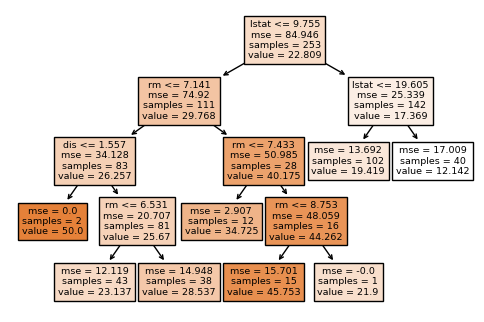

In [63]:

# we can get the tree structure as string 
treeAsText: str = sklearn.tree.export_text (decisionTreeModel, feature_names = X.columns.to_list ())

# or image using the standard built in plot_tree 
pyplot.subplots (nrows = 1, ncols = 1, figsize = (6, 4), dpi = 100)
ignore = sklearn.tree.plot_tree (decisionTreeModel, feature_names = X.columns.to_list (), class_names=["Low", "High"], filled = True)

# There are other visualization libraries like graphviz which require
# additional installations that can be managed by Anaconda. 
# sklearn.tree.export_graphviz ()

## Fitting the Model with Cross-Validation 

We will now use the training data set for cross-validation. In R, we take the fitted tree and use a specialized method that is from the same `tree` package. In Python, we can either create a k-fold set of data sets ourselves using the cross validation train test split (`sklearn.cross_validation.train_test_split`) or use the `sklearn.model_selection.GridSearchCV` to perform the split and fit the model. We will use the latter.

After using cross-validation to find the best model, we will use the best model and the test data set (with data the model has never seen) to get the test error rate. Finally, we will increase the tree size similar to how it was done in R and get that test error rate. 

Python uses the GridSearchCV and provides access to the `best_estimator_` property that contains the best fitted estimator. We do not have to "prune" the originally fit tree manually.

R Code
```R
# cross-validation trees
cv.boston = cv.tree (tree.boston)
plot (cv.boston$size, cv.boston$dev, type = "b")

prune.boston = prune.tree (tree.boston, best = 5)
plot (prune.boston)
text (prune.boston, pretty = 0)

Boston [-train, "medv"]

yhat = predict(tree.boston, newdata = Boston [-train,])
boston.test = Boston [-train, "medv"]
plot (yhat, boston.test)
abline (0, 1)
mean ((yhat - boston.test)^2)
```

In [97]:
# set the seed for repeatable results
numpy.random.seed (2) # this seed has results that approximately mirror R results

# use the train test splitter to split randomly into data sets (50% each)
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split (X, y, test_size = 0.50)

# hyperparameters (this is a require parameter on the GridSearchCV)
# let's limit the grid search to the 
hyperparameters = { "max_leaf_nodes": range (0, 15) } 
decisionTreeGrid: GridSearchCV = GridSearchCV (estimator = DecisionTreeRegressor (), param_grid = hyperparameters)
decisionTreeGrid.fit (trainX, trainy)
decisionTreeNodes = DecisionTreeSummary (decisionTreeGrid.best_estimator_, trainX, trainy, testX, testy)


Classification tree: 
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=6,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Variables actually used in tree construction:
Index(['rm', 'dis', 'black', 'lstat'], dtype='object')
Number of terminal nodes: 6
Residual mean deviance: 14.6809 = 3626.19 / 247
Distribution of residuals: 
   count   mean    std     min    25%    50%    75%    max
0  253.0 -0.194  6.376 -25.842 -3.436 -1.036  2.738  28.24


In [98]:
# let's print out the mean cross validation error rate for each parameter tested
cvResults = numpy.column_stack ((decisionTreeGrid.cv_results_ ["params"], numpy.round (decisionTreeGrid.cv_results_ ["mean_test_score"], 4)))

# higher is better as the score is simply the classification rate
print ("Best cross-validation result: ")
print (cvResults [decisionTreeGrid.best_index_])
print ("\nAll mean cross-validation results: ")
print (cvResults)

Best cross-validation result: 
[{'max_leaf_nodes': 6} 0.589]

All mean cross-validation results: 
[[{'max_leaf_nodes': 0} nan]
 [{'max_leaf_nodes': 1} nan]
 [{'max_leaf_nodes': 2} 0.3112]
 [{'max_leaf_nodes': 3} 0.5507]
 [{'max_leaf_nodes': 4} 0.5641]
 [{'max_leaf_nodes': 5} 0.5756]
 [{'max_leaf_nodes': 6} 0.589]
 [{'max_leaf_nodes': 7} 0.5684]
 [{'max_leaf_nodes': 8} 0.581]
 [{'max_leaf_nodes': 9} 0.5755]
 [{'max_leaf_nodes': 10} 0.5734]
 [{'max_leaf_nodes': 11} 0.5761]
 [{'max_leaf_nodes': 12} 0.5802]
 [{'max_leaf_nodes': 13} 0.5627]
 [{'max_leaf_nodes': 14} 0.58]]


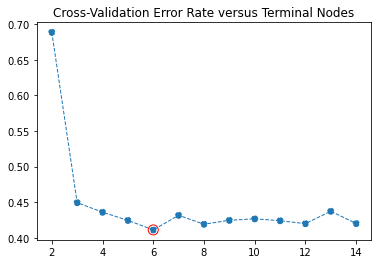

In [103]:
# plot the cross-validation error by terminal nodes
figure, axes = pyplot.subplots ()
axes.plot (range (0, 15), 1 - decisionTreeGrid.cv_results_["mean_test_score"], linestyle = "--", linewidth = 1)
axes.scatter (range (0, 15), 1 - decisionTreeGrid.cv_results_["mean_test_score"], linestyle = "--", linewidth = 1)
axes.set_title ("MSE versus Terminal Nodes")

# plot the best performing set of terminal nodes
best_x = (cvResults [decisionTreeGrid.best_index_])[0]["max_leaf_nodes"]
best_y = 1 - (cvResults [decisionTreeGrid.best_index_])[1]
axes.scatter(best_x, best_y, s=100, linewidth=1, facecolors='none', edgecolors='r')


The plot shows the mean square error (MSE) with the number of terminal nodes. The highlighted point is the lowest error rate at terminal nodes 6, which is selected for the best model.

## Predicting with Best Estimator

In [119]:
yhat = decisionTreeGrid.best_estimator_.predict (testX)
residuals = testy - yhat
mse = numpy.mean (numpy.square (residuals))
mse_sqrt = numpy.sqrt (mse)

print ("The MSE for the test set is: {:.4f}".format (mse))
print ("The SQRT of the MSE is: {:.4f}".format (mse_sqrt))
print ("We expect the test predictions are within approximately ${:.0f} of the true median home value for the suburb.".format (mse_sqrt * 1000))


The MSE for the test set is: 40.5256
The SQRT of the MSE is: 6.3660
We expect the test predictions are within approximately $6366 of the true median home value for the suburb.
